In [35]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns

transcript = pd.read_json('data/transcript.json', orient='records', convert_dates = ['time'], lines=True)
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
cleaned_profile = profile.dropna()

In [3]:
def expand_transcript(transcript = transcript):
    '''
    Unpacks the dictionary in the 'value' column of the transcript and combines values from 'offer_id' and 'offer id' keys.
    
    input
    transcript- the transcript file from transcript.json
    
    output
    expanded_transcript- the transcript with columns added the unpack the dictionary in the 'values' column
    
    '''
    new_columns = pd.DataFrame(transcript['value'].apply(pd.Series))
    new_columns['offer id'].fillna(new_columns['offer_id'], inplace = True)
    new_columns.drop(columns='offer_id', inplace = True)
    expanded_transcript = pd.concat([transcript, new_columns], axis =1)
    return (expanded_transcript)
expanded_transcript = expand_transcript()

In [4]:
def create_datetime_objects(num):
    '''Turn our 'time' column into a date we can use for this analysis. I chose the start of the next month after our last
    signup in the profile but really any date will do.
    input
    num - Our 0 to 714 number from the time column representing hours passed in the experiment
    
    output
    date_and_time - the time down to the hour the event in the transcript takes place
    '''
    date = datetime.strptime(str(2018080108), '%Y%m%d%H')
    td = timedelta(hours=num)
    date_and_time =date+td
    return (date_and_time)
expanded_transcript['date'] = expanded_transcript['time'].apply(create_datetime_objects)

In [5]:
def convert_date(num):
    '''
    Take a date in format YYYYMMDD and convert it into the number of days from that date to the day after the last signup.
    
    input
    num - the YYYYMMDD date from the profile
    
    output
    diff.days - the differnce between the "current" date (day after last signup) and the date inputed, converted to days. 
    
    '''
    date = datetime.strptime(str(num), '%Y%m%d')
    #day after last sign up in profile
    start_date = datetime.strptime(str(20180727), '%Y%m%d')
    diff = start_date -date #date.days()
    return (diff.days)

In [6]:
def preprocess_profile(profile = profile):
    '''Run preprocessing on the profile.
    
    input
    profile- a version of the profile (normally cleaned_profile from clean_profile_and_master)
    
    output
    preprocessed_profile - profile after preprocessing(convert_date, scaling, and one-hot encoding)
    '''
    profile['days_member'] = profile['became_member_on'].apply(convert_date)
    preprocessed_profile = profile.drop(columns='became_member_on')
    scaler = StandardScaler() 
    num = ['age', 'income', 'days_member']

    preprocessed_profile[num] = scaler.fit_transform(preprocessed_profile[num])
    preprocessed_profile.set_index('id', inplace = True)
    preprocessed_profile = pd.get_dummies(preprocessed_profile)
    return(preprocessed_profile)
preprocessed_profile = preprocess_profile(cleaned_profile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [11]:
k_scores = []
k_test_set = np.arange(100, 300, 25)

for k in k_test_set:
    k_means_attempt = MiniBatchKMeans(k)
    fitted_k_means = k_means_attempt.fit(preprocessed_profile)
    
    k_score = k_means_attempt.score(preprocessed_profile)
    k_scores.append(k_score)
k_scores

[-3788.9170555891865,
 -3334.202013101356,
 -2870.5731275307899,
 -2949.7371445421177,
 -2728.7767212645394,
 -2226.6993980074631,
 -2070.1022940753251,
 -1942.9104780540013]

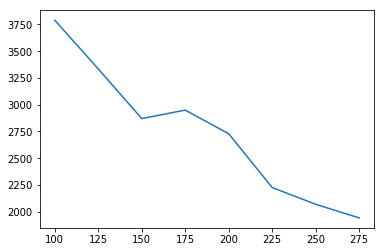

In [12]:
import matplotlib.pyplot as plt
abs_k_scores = [abs(score) for score in k_scores]

plt.plot(k_test_set, abs_k_scores)

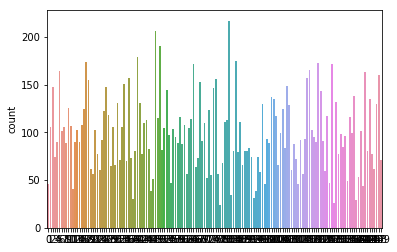

In [13]:


k_means = KMeans(150, random_state = 4)
k_means_predict = k_means.fit_predict(preprocessed_profile)
sns.countplot(k_means_predict)

In [15]:
def prepare_data_for_prophet (clust, transcript = expanded_transcript):
    '''Take data from the expanded transcript and convert it to prepare for test/train splits. Then perform the splits.
    
    inputs
    
    clust - a set of user ids for all individuals in a cluster
    expanded_transcript - the latest transcript file with added columns
    
    outputs
    X_train, X_test - a column of timestamps when transactions took place.
    y_train, y_test- a column of transaction amounts
    z_train, z_test- columns of dummy variables for influencing offers
    
    
    '''
    
    transactions = transcript[transcript['event']=='transaction']
    
    uno_transactions  = pd.DataFrame(transactions[transactions['person'].isin(clust)])
    df = pd.get_dummies(uno_transactions, columns = ['influencing offer'])

    X = df['date']
    
    y = df['amount']
    z = df.drop(columns =['date','amount','event', 'person', 'time', 'value', 'offer id', 'reward'])
    tscv = TimeSeriesSplit(n_splits=3)
     

    for train_index, test_index in tscv.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        z_train, z_test = z.iloc[train_index], z.iloc[test_index]
    return (X_train, y_train, X_test, y_test, z_train, z_test)

In [16]:
expanded_transcript['influencing offer'] = np.nan
for customer in transcript['person'].unique():
    everything = expanded_transcript[transcript['person'] == customer]
    received = everything[everything['event'] == 'offer received']
    transactions = everything[everything['event'] == 'transaction']
    transaction_times = transactions['time']
    completions = everything[everything['event'] == 'offer completed']
    completion_times = completions['time']
    views = everything[everything['event'] == 'offer viewed']
    view_times = views['time']
    
    for receipt in received.iterrows():
            
            iloc = receipt[0]
            offer_id = receipt[1]['offer id']
            
            offer_row = portfolio[portfolio['id'] == offer_id]
                
            offer_length = offer_row['duration']
            offer_hours = 24*offer_length
            offer_start = received.loc[iloc]['time']
            offer_end= offer_start+ offer_hours
            offer_end = offer_end.values[0]
            #try:
            views_range = view_times.where(everything['time'].isin(np.arange(offer_start, offer_end+1))).dropna().index
            #print(views_range)
            views_in_range = expanded_transcript.loc[views_range]
            #print (offer_end)
            if len(views_in_range) > 0:
                if len(views_in_range[views_in_range['offer id'] == offer_id]) >0:
                    offer_viewed = views_in_range[views_in_range['offer id'] == offer_id]['time'].values[0]
                
            
                    completions_range = completion_times.where(everything['time'].isin(np.arange(offer_start, offer_end+1))).dropna().index
                    completions_in_range = completions.loc[completions_range]
                    if len(completions_in_range) > 0:
                        if len(completions_in_range[completions_in_range['offer id'] == offer_id]) >0:
                            offer_end = completions_in_range[completions_in_range['offer id'] == offer_id]['time'].values[0]

                
                   
                    influenced = transaction_times.where(everything['time'].isin(np.arange(offer_viewed, offer_end+1))).dropna().index
                
                    
                    for influenced_transaction in influenced:
                        expanded_transcript.ix[influenced_transaction, 'influencing offer'] = offer_id


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [17]:
expanded_transcript.to_csv('expanded_transcript_with_influence', index = False)

In [67]:
expanded_transcript = pd.read_csv('expanded_transcript_with_influence')

In [20]:
def run_prophet (X_train, y_train, X_test, y_test, z_train, z_test):
    '''Fit prophet on the training data and get predictions for the testing data
    
    inputs
    X_train, X_test - a column of timestamps when transactions took place.
    y_train, y_test- a column of transaction amounts
    z_train, z_test- columns of dummy variables for influencing offers
    
    output
    forecast -a large dataframe with predictions and information about what factors influenced those predictions
    '''
    
    train =pd.DataFrame({'ds':X_train, 'y': y_train})
    m = Prophet()
    for column in z_train.columns:
        train[column] = z_train[column]
        m.add_regressor(column)
    m.fit(train)
    future = pd.DataFrame({'ds':X_test})
    for column in z_test.columns:
        future[column] = z_test[column]
    present = train.drop(columns = 'y')
    forecast = m.predict(future)
    
    return (forecast)

In [25]:
def iterate_clusters(clusters):
    '''Run a fit and predict in prophet for each cluster created by K-Means. Test the y_hat from the forecast file against the
    testing data and general mse and mae.
    
    input
    clusters- list of all user ids with their assigned cluster
    
    output
    none - prints overall mae and mse
    '''
    maes = []
    mses = []
    for cluster in np.unique(id_clusters[0].values):
        clust = pd.Series(id_clusters[id_clusters[0] ==cluster].index.values)
        no_outliers = expanded_transcript[expanded_transcript['amount'] < 100]
        X_train, y_train, X_test, y_test, z_train, z_test = prepare_data_for_prophet(clust, no_outliers)
        forecast = run_prophet (X_train, y_train, X_test, y_test, z_train, z_test)
        
        mae = mean_absolute_error(forecast['yhat'].values, y_test.values)
        mse = mean_squared_error(forecast['yhat'].values, y_test.values)
        maes.append(mae)
        mses.append(mse)
    print(np.mean(maes))
    print(np.mean(mses))

id_clusters = pd.DataFrame(k_means_predict, index = preprocessed_profile.index)
iterate_clusters(id_clusters)



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

5.4380311993
53.6837058971


In [39]:
id_clusters

,0
id,
0610b486422d4921ae7d2bf64640c50b,96
78afa995795e4d85b5d9ceeca43f5fef,98
e2127556f4f64592b11af22de27a7932,65
389bc3fa690240e798340f5a15918d5c,101
2eeac8d8feae4a8cad5a6af0499a211d,142
aa4862eba776480b8bb9c68455b8c2e1,137
e12aeaf2d47d42479ea1c4ac3d8286c6,20
31dda685af34476cad5bc968bdb01c53,104
62cf5e10845442329191fc246e7bcea3,58
